<a href="https://colab.research.google.com/github/sattwiksuman/AI_for_Trash_Collection/blob/discrete_environment/Trash_Collection_RL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<center>Efficient Trash Collection using AI</center>
---
####<center>Reinforced Learning Project - Economic Modelling of Energy and Climate Systems</center>
####<center>Data Analytics and Decision Science</center>
####<center>RWTH Aachen Business School</center>
Submitted by:<br>
Priyanka Kundagol<br>
Sattwik Suman Das<br>
Ved Nerlikar



---
#Introduction

---

Combinatorial Optimization problems such as vehicle routing problem or travelling salesman problems have been traditionally solved by using Operations Research concepts and Heuristic approaches. In the recent years however, Reinforcement Learning techniques based on Markov Decision Process and Q-learning have been implemented to explore training Deep Neural Networks to learn the optimal policy for an agent’s actions based on an appropriately implemented environment and suitably designed reward function [2][3].

In our quest for a topic that used Reinforcement Learning methodologies to model climate effects, we stumbled upon a paper “Automated Trash Collection using Markov Decision Processes” by Robert J. Moss, Stanford [1]. It gave us an insight into how a grid-based environment can be simulated to model the roads of a city and an agent can be trained to collect garbage from specific locations. We implemented this as part of our project. The details of the implementation can be seen in the following blocks of the notebook.

Trash is usually collected by the municipal bodies by trucks that run on pre-defined routes at pre-defined intervals of time. The paper [1] proposes a smart system where the truck automatically senses the level of trash at each garbage location and determines the best path it can take to collect the trash. This is expected to optimize the distance covered by these trucks thus helping in fuel savings and more efficient scheduling.

Further applications of this principle might also be in automated trash collection from garbage bins at hospital corridors. We also see similar applications in warehouses [3] or production lines where robots can be used to automatically replenish items at the workstations. All these applications are motivated by enhancing the efficiency of operations which can manifest into several benefits.

###The Environment
The Diagram below shows the environment in which the Agent would operate.
The squares in gray are the road.
The Agent is expected to collect trash from the location shown in Black boxes.
The trash is actually collected from the adjacent squares marked by a dark border on the road, i.e., squares 3, 17 and 21.

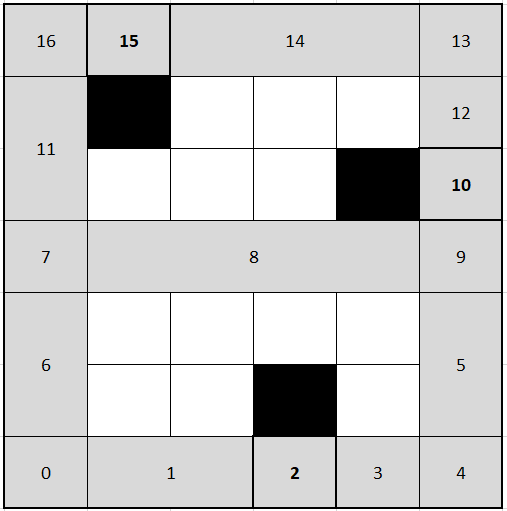

###States of the Environment:
The gray squares above depict the states in which the agent can reside. <br>
So there are 26 states in total numbered 0 to 25. <br>
The movement of the agent from one state to another is defined by defining the rewards of the adjacent states.

###Actions
At each state the agent can 5 actions as follows:
0. Do nothing
1. Move North
2. Move East
3. Move South
4. Move West 

###Action_Space: control the motion
For each state, the next state corresponding to the consequence of the 5 actions will be pre-defined as part of the environment definition. 

###Rewards
The reward of the trash locations 03, 17 and 21 are defined to reflect the amount of trash in the following manner:
1. if trash >= threshold:
        reward= percentage of trash bin full
2. else:
        reward = 0
<br>
The threshold can be set to 70% .

###Reward for road states in form of Living Penalty
A Living Penalty is defined to each of the states on the road because we want the agent to move by taking the shortest time, which would ultimately be the most efficient way to travel. <br>
Living Penalty is not defined to the start location '0' and the trash locations. <br>
The agent is expected to reside at the starting point till it needs to make it's first trip and then reside at the location from which it has collected the trash till it needs to move to the next location to collect from the next location.<br>
Living penalty can be set to -0.2

###Carrying capacity of the Agent
For the initial model, the agent is assumed to have infinite capacity. <br>
This effectively means it never has to return to the depot to empty itself.

###Timestep of the simulation
The timestep can be assumed to be one hour.<br>
In each timestep:
1. the vehicle is assumed to have one state transition.
2. the garbage is updated to new quatities

###Implementation history:
The environment implementation as described above remained evolved from a first model where the there were just individual square blocks marking the states of the system. In order to reduce the state space for more efficient training, we merged adjacent blocks which were not at a junction or were not garbage locations. The living penalty for these locations was then set according to their size.

A simple neural network was first employed with an input layer, two hidden layers with attached dropout layers and one output layer as the brain of the Deep Q Learning algorithm. The model can be seen after the training block below. We further introduced weight initialization using a Xavier initialization approach to get better results.

A lot of iterations were made trying out different reward strategies:
1.	Upon trying the first reward function of giving living penalty = -0.2 to all states depending on their size, 0 reward to location 0 and reward = garbage quantity if garbage quantity > 70% for garbage locations, it was seen that the agent preferred to just stay at the origin and accumulate zero reward rather than moving around and accumulating negative rewards.
2.	Then a next attempt was made where the reward function for location 0 was changed to base value of living penalty in case the garbage quantity at any garbage location went above 70%. However, that also didn't improve the result and the agent just wandered around location 0 and didn't collect the garbage at all.
3.	A fundamental error in implementation was detected and the reward function was subsequently scaled by dividing the reward by 1000. Errors in update of reward space in step function of the environment were also corrected and further simulations were done. The Agent was now seen to be moving to the nearest garbage location and settling there rather than collecting the garbage at all locations. It just moves out and enters the garbage location 2 when garbage builds up in that location.
4.	The next strategy was to increase the base value of living penalty when the garbage value in a garbage location went beyond 0.95 with the aim to not allow the garbage locations to fill beyond 100%. However, this didn’t result in any improvement of the result. Trials were done with different values of base value and increased base value of living penalty.
5.	Further reading suggested that the number of timesteps on which to train the model must be very large (of the order of million as opposed to roughly 70000 step we had trained at maximum). We are using Google Colab to build and train our model the free version of which has a maximum run time of 12 hours. We tried to save the models and then export pre saved models to continue training. However even with this and the limited time we could afford to devote to training a particular strategy, we were not able to see significant improvement in performance.



---
#Importing the packages
---

In [ ]:
#Mount the storage space on google drive to save the models and load later
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import gym
from gym import spaces

import numpy as np
from numpy.random import default_rng
from random import random
from random import randint
import pandas as pd
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

import tensorflow as tf

from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam

from keras.models import load_model

---
#Building the Environment
---

In [ ]:
#Build the environment

class TrashEnv(gym.Env):

    def __init__(self):
        super(TrashEnv, self).__init__()
        # Define action and observation space
        # Gym environment is not used. Rather a grid world is created from scratch.
        n_actions = 5
        #self.action_space = spaces.Discrete(n_actions)

        self.total_states = 17
        self.observation_space = spaces.Discrete(self.total_states)

        #Define the action space:
        self.action_space = {}
        self.action_space[0]={0:0, 1:6, 2:1, 3:0, 4:0}
        self.action_space[1]={0:1, 1:1, 2:2, 3:1, 4:0}
        self.action_space[2]={0:2, 1:2, 2:3, 3:2, 4:1}
        self.action_space[3]={0:3, 1:3, 2:4, 3:3, 4:2}
        self.action_space[4]={0:4, 1:5, 2:4, 3:4, 4:3}
        self.action_space[5]={0:5, 1:9, 2:5, 3:4, 4:5}
        self.action_space[6]={0:6, 1:7, 2:6, 3:0, 4:6}
        self.action_space[7]={0:7, 1:11, 2:8, 3:6, 4:7}
        self.action_space[8]={0:8, 1:8, 2:9, 3:8, 4:7}
        self.action_space[9]={0:9, 1:10, 2:9, 3:5, 4:8}
        self.action_space[10]={0:10, 1:12, 2:10, 3:9, 4:10}
        self.action_space[11]={0:11, 1:16, 2:11, 3:7, 4:11}
        self.action_space[12]={0:12, 1:13, 2:12, 3:10, 4:12}
        self.action_space[13]={0:13, 1:13, 2:13, 3:12, 4:14}
        self.action_space[14]={0:14, 1:14, 2:13, 3:14, 4:15}
        self.action_space[15]={0:15, 1:15, 2:14, 3:15, 4:16}
        self.action_space[16]={0:16, 1:16, 2:15, 3:11, 4:16}
        
        #Define the Garbage locations and corresponding initial garbage quantity values = 0:
        self.garbage_quantity = {}
        self.garbage_locations = [2, 10, 15]
        for l in self.garbage_locations:
            self.garbage_quantity[l]=0.0  

        #Define maximum quatity of garbage that would be updated in one timestep:
        self.max_garbage_update = 0.04   

        #Define threshold after which garbage updation reflects in reward:
        self.garbage_threshold = 0.7
        
        # Set the living penalty
        self.base_value = -1
        self.high_value = -10
        self.living_penalty_base_value = self.base_value
        
        # living penalty is assigned according to the size of the state: refer to diagram attached above
        self.living_penalty = self.update_living_penalty()
        
        #Define the Rewards:
        #reward_space is defined as a dictionary of dictionaries {current_state:{action:reward}}
        self.reward_space = {}
        for i in range(len(self.action_space)):
            self.reward_space[i] = self.update_reward(i)

        # Create state attribute, initialize it in reset method
        self.state = None

        #Create a variable to measure the distance covered
        #This will be compared against the distance covered in the naive approach
        self.distance_covered = 0

        #Create a variable to store the number of timesteps
        #This can be used to define an epoch
        self.current_time = 0

        #Create a variable to set the status of training to Train or Test or None
        #This allows us not to run the training everytime we run the whole notebook
        self.train = None
        
        
    def step(self, action):
        """State transition of the model.
        Implements the model of the environment.
        Args:
            action (int): Action the agent took.
        Returns:
            next_state (int): The next state the environment emits.
            reward (float): The reward the environment emits.
            done (bool): Currently always set to 0 as we are modelling a continuous process
            garbage_info (dict): Info about the rewards at the garbage locations {loc: reward}
        """

        # Calculate the next state
        next_state = self.action_space[self.state[0]][action]

        # Calculate the reward
        ##Reward can not be set after update of the reward_space following the action
        ##because the reward_space will update the garbage location to zero in case the agent arrives there giving the agent 0 reward.
        reward = self.reward_space[self.state[0]][action]
        reward = 1e-3 * reward  #scaling of reward

        #If reward of any garbage location is non zero, then living penalty at location 0 is 2 * living penalty base value
        #If the garbage quantity at any garbage location reaches 0.95, the living penalty base value increases
        #Otherwise the agent just learns to stay at the location 0 as it maximizes reward. 
        if all(x==0 for x in [self.reward_space[l][0] for l in self.garbage_locations]):
            self.living_penalty[0]=0
        else:
            if True in [item>0.95 for item in [self.reward_space[l][0] for l in self.garbage_locations]]:
                self.living_penalty_base_value = self.high_value
                self.living_penalty = self.update_living_penalty()
            else:
                self.living_penalty_base_value = self.base_value
                self.living_penalty = self.update_living_penalty()
            self.living_penalty[0]=2*self.living_penalty_base_value
        self.reward_space[0]=self.update_reward(0)

        #Update the garbage_quantity and reward_space:
        if next_state not in self.garbage_locations:    #in free area or stepping out of garbage location
            for l in self.garbage_locations:
                self.garbage_quantity[l]+=random()*self.max_garbage_update
                for i in range(len(self.action_space)):
                    self.reward_space[i] = self.update_reward(i)
        else:
            if self.state[0] not in self.garbage_locations:
                for l in self.garbage_locations:
                    if l == next_state:         #stepping into garbage location
                        self.garbage_quantity[l]=0.0
                        for i in range(len(self.action_space)):
                            self.reward_space[i] = self.update_reward(i)
                    else:       #this else statement should never be true
                        self.garbage_quantity[l]+=random()*self.max_garbage_update
                        self.reward_space[l]=self.update_reward(l)
            else:       #waiting at a garbage location
                for l in self.garbage_locations:
                    self.garbage_quantity[l]+=random()*self.max_garbage_update
                    for i in range(len(self.action_space)):
                        self.reward_space[i] = self.update_reward(i)

        #The episode will be continuous, so there will be no 'Game Over'/ 'Done'
        done = 0

        self.garbage_info = {self.garbage_locations[i]: self.reward_space[l] for i, l in enumerate(self.garbage_locations)}

        #Update the distance covered
        if self.state[0] != next_state:
            self.distance_covered += 1 

        #Update the current time
        self.current_time += 1

        #Update the state to the next state:
        self.state = [next_state]
        for l in self.garbage_locations:
            self.state.append(self.garbage_quantity[l])
        return self.state, reward, done, self.garbage_info


    def reset(self):
        """Resets the environment.
        Initializes the state.
        Returns:
            state (int): [state, garbage_quantity at garbage locations]
            garbage_info (dict): Info about the rewards at the garbage locations {loc: reward}
        """
        self.state = [0]
        for l in self.garbage_locations:
            self.garbage_quantity[l]=0.0
            self.state.append(self.garbage_quantity[l])
            self.reward_space[l]=self.update_reward(l)
        self.distance_covered = 0
        self.current_time = 0
        self.garbage_info = {self.garbage_locations[i]: self.reward_space[l] for i, l in enumerate(self.garbage_locations)}
        return self.state

    #Update living penalty at all locations:
    def update_living_penalty(self):
        self.living_penalty = {0:0,              #reward for initial location must be zero as we allow the agent to reside at 0 before it has to start
                            1:2*self.living_penalty_base_value,
                            2:0,              #reward for garbage location would be assigned later. it is just initialized with 0.
                            3:self.living_penalty_base_value,
                            4:self.living_penalty_base_value,
                            5:2*self.living_penalty_base_value,
                            6:2*self.living_penalty_base_value,
                            7:self.living_penalty_base_value, 
                            8:4*self.living_penalty_base_value,
                            9:self.living_penalty_base_value,
                            10:0,
                            11:2*self.living_penalty_base_value,
                            12:self.living_penalty_base_value,
                            13:self.living_penalty_base_value,
                            14:3*self.living_penalty_base_value,
                            15:0,
                            16:self.living_penalty_base_value
                            }
        return self.living_penalty

    #Define update reward function:
    def update_reward(self, location):
        i= location
        dummy_dict={}
        for act, j in zip(self.action_space[i].keys(), self.action_space[i].values()):
            dummy_dict[act]=self.living_penalty[j]
            if j in self.garbage_locations:
                dummy_dict[act]=self.update_garbage_reward(j)
            if act!=0 and j==i:     #larger penalty for infeasible actions
                dummy_dict[act]=2*dummy_dict[act]
                if i in self.garbage_locations:
                    dummy_dict[act]=self.living_penalty_base_value
        return dummy_dict

    def update_garbage_reward(self, garbage_location):
        """Updates the reward space at a garbage location based on the quantity of garbage at the location
        Returns:
            reward_space[garbage_location]
        """
        i=garbage_location
        if i in self.garbage_locations:
                if self.garbage_quantity[i] > 0.7:
                    dummy_reward=self.garbage_quantity[i]*100 
                else:
                    dummy_reward=0.0
        return(dummy_reward)        #self.reward_space[i]

    # We will not implement render and close function
    def render(self, mode='human'):
        pass
    def close (self):
        pass

---
#Testing the environment
---

In [ ]:
# Create the environment
test_env = TrashEnv()

# Reset the environment to get initial state
state = test_env.reset()
state = state[0]
print(test_env.garbage_info)
print(test_env.reward_space[2])

# Create a list to store all states during the simulation
columns=['action', 'state', 'reward']
for key in test_env.garbage_info.keys():
    columns.append(f'reward_at_garbage_{key}')
for key in test_env.garbage_info.keys():
    columns.append(f'garbage_quantity_at_{key}')

row = {'action': 'Initialize', 'state':state, 'reward': 0.0}
for key, val in zip(columns[3:6], test_env.garbage_info.values()):
    row[key]=val
for key, val in zip(columns[6:], test_env.garbage_quantity.values()):
    row[key]=val
print(row)

#Pandas DataFrame test_log stores the state, action, reward and garbage parameters at each timestep. 
test_log = pd.DataFrame(columns=columns)
test_log = test_log.append(row, ignore_index=True)  #the first row is the start position

# Loop over each time step in the episode
done = False
for _ in range(100):
    action = randint(0,4)
    state, reward, _, garbage_info = test_env.step(action)
    state=state[0]
    #print('state', state)  #for debugging
    row = {'action':action, 'state':state, 'reward': reward}
    for key, val in zip(columns[3:], garbage_info.values()):
        row[key]=val
    for key, val in zip(columns[6:], test_env.garbage_quantity.values()):
        row[key]=val
    test_log = test_log.append(row, ignore_index=True)

{2: {0: 0.0, 1: -1, 2: -1, 3: -1, 4: -2}, 10: {0: 0.0, 1: -1, 2: -1, 3: -1, 4: -1}, 15: {0: 0.0, 1: -1, 2: -3, 3: -1, 4: -1}}
{0: 0.0, 1: -1, 2: -1, 3: -1, 4: -2}
{'action': 'Initialize', 'state': 0, 'reward': 0.0, 'reward_at_garbage_2': {0: 0.0, 1: -1, 2: -1, 3: -1, 4: -2}, 'reward_at_garbage_10': {0: 0.0, 1: -1, 2: -1, 3: -1, 4: -1}, 'reward_at_garbage_15': {0: 0.0, 1: -1, 2: -3, 3: -1, 4: -1}, 'garbage_quantity_at_2': 0.0, 'garbage_quantity_at_10': 0.0, 'garbage_quantity_at_15': 0.0}


In [ ]:
 test_log.loc[50:100]

,action,state,reward,reward_at_garbage_2,reward_at_garbage_10,reward_at_garbage_15,garbage_quantity_at_2,garbage_quantity_at_10,garbage_quantity_at_15
50,4,16,-0.02,"{0: 85.2906366846082, 1: -10, 2: -10, 3: -10, ...","{0: 113.6349912426506, 1: -10, 2: -10, 3: -10,...","{0: 0.0, 1: -10, 2: -30, 3: -10, 4: -10}",0.852906,1.136350,0.097019
51,0,16,-0.01,"{0: 88.02770193457565, 1: -10, 2: -10, 3: -10,...","{0: 115.06173807157829, 1: -10, 2: -10, 3: -10...","{0: 0.0, 1: -10, 2: -30, 3: -10, 4: -10}",0.880277,1.150617,0.122919
52,2,15,0.00,"{0: 89.85457120287138, 1: -10, 2: -10, 3: -10,...","{0: 118.21434383057965, 1: -10, 2: -10, 3: -10...","{0: 0.0, 1: -10, 2: -30, 3: -10, 4: -10}",0.898546,1.182143,0.000000
53,2,14,-0.03,"{0: 93.28769844268045, 1: -10, 2: -10, 3: -10,...","{0: 121.02152857929305, 1: -10, 2: -10, 3: -10...","{0: 0.0, 1: -10, 2: -30, 3: -10, 4: -10}",0.932877,1.210215,0.004039
54,4,15,0.00,"{0: 95.05761651758111, 1: -10, 2: -10, 3: -10,...","{0: 124.28186988551798, 1: -10, 2: -10, 3: -10...","{0: 0.0, 1: -10, 2: -30, 3: -10, 4: -10}",0.950576,1.242819,0.000000
55,3,15,-0.01,"{0: 95.76219338883533, 1: -10, 2: -10, 3: -10,...","{0: 125.20492394302853, 1: -10, 2: -10, 3: -10...","{0: 0.0, 1: -10, 2: -30, 3: -10, 4: -10}",0.957622,1.252049,0.008529
56,2,14,-0.03,"{0: 96.6662476090209, 1: -10, 2: -10, 3: -10, ...","{0: 128.70815108109585, 1: -10, 2: -10, 3: -10...","{0: 0.0, 1: -10, 2: -30, 3: -10, 4: -10}",0.966662,1.287082,0.023869
57,3,14,-0.06,"{0: 98.04093554267507, 1: -10, 2: -10, 3: -10,...","{0: 132.45924420143083, 1: -10, 2: -10, 3: -10...","{0: 0.0, 1: -10, 2: -30, 3: -10, 4: -10}",0.980409,1.324592,0.041341
58,4,15,0.00,"{0: 99.22407148408828, 1: -10, 2: -10, 3: -10,...","{0: 133.6394281209433, 1: -10, 2: -10, 3: -10,...","{0: 0.0, 1: -10, 2: -30, 3: -10, 4: -10}",0.992241,1.336394,0.000000
59,2,14,-0.03,"{0: 99.31718326274532, 1: -10, 2: -10, 3: -10,...","{0: 136.0610365117154, 1: -10, 2: -10, 3: -10,...","{0: 0.0, 1: -10, 2: -30, 3: -10, 4: -10}",0.993172,1.360610,0.019751


---
#Building the Brain
---

In [ ]:
#Build the Brain
'''
BRAIN PARAMETERS (TBD):

Input Layer: Should we just have the current state as the input or the current state
            along with the garbage levels / rewards of the garbage locations as the input
Output layer: output layer will have 5 nodes corresponding to the Q values
            of the 5 possible actions possible for each state
Dense layers: 2 dense layers with 10 nodes each #suggestion
Compiler:
    loss:'mse'
    optimizer: 'Adam'
    learning_rate= 0.001
    #suggestions
'''

# BUILDING THE BRAIN

class Brain(object):
    
    # BUILDING A FULLY CONNECTED NEURAL NETWORK DIRECTLY INSIDE THE INIT METHOD
    
    def __init__(self, learning_rate = 0.001, number_of_state_params = 4, number_actions = 5):
        
        self.learning_rate = learning_rate
        
        # BUILDIND THE INPUT LAYER COMPOSED OF THE INPUT STATE
        states = Input(shape = (number_of_state_params,))

        #BUILDING THE INITIALIZER FOR XAVIER WEIGHT INITIALIZATION:
        #weights are initialized to sqrt(1/fan_in+fan_out)
        initializer = tf.keras.initializers.GlorotUniform()
        
        # BUILDING THE FIRST FULLY CONNECTED HIDDEN LAYER WITH DROPOUT ACTIVATED
        x = Dense(units = 64, activation = 'sigmoid', kernel_initializer=initializer)(states)
        x = Dropout(rate = 0.1)(x)
        
        # BUILDING THE SECOND FULLY CONNECTED HIDDEN LAYER WITH DROPOUT ACTIVATED
        y = Dense(units = 32, activation = 'sigmoid', kernel_initializer=initializer)(x)
        y = Dropout(rate = 0.1)(y)
        
        # BUILDING THE OUTPUT LAYER, FULLY CONNECTED TO THE LAST HIDDEN LAYER
        output_initializer = tf.keras.initializers.Zeros()
        q_values = Dense(units = number_actions, activation = 'softmax', kernel_initializer = output_initializer)(y)
        
        # ASSEMBLING THE FULL ARCHITECTURE INSIDE A MODEL OBJECT
        self.model = Model(inputs = states, outputs = q_values)
        
        # COMPILING THE MODEL WITH A MEAN-SQUARED ERROR LOSS AND A CHOSEN OPTIMIZER
        self.model.compile(loss = 'mse', optimizer = Adam(lr = learning_rate))



---
#Creating a DQN Object (Agent)
---

In [ ]:
#Build the DQN object = Agent
'''
PARAMETERS:

memory: list of length memory_len (we can model this as a queue)
memory_max_len: length of the memory = 50 (approximately 2 days worth of timesteps)
discount: 0.9
'''

class DQN():

    def __init__(self, max_memory = 50, discount = 0.9):
        self.memory = list()
        self.max_memory = max_memory
        self.discount = discount

    '''
    METHODS:

    get_action:
        take the current_state as input and predict the action
        using epsilon delta: random or argmax(predicted Q_values for current_state)
        returns: action
    '''
    def get_action(self, model, current_state, epsilon=0.3):
        
        # PLAYING THE NEXT ACTION BY EXPLORATION
        if np.random.rand() <= epsilon:
            action = np.random.randint(0, number_actions)
        
        # PLAYING THE NEXT ACTION BY INFERENCE
        else:
            q_values = model.predict(np.array(np.matrix(current_state)))   #current_state.shape = (4,)
            action = np.argmax(q_values[0])
        
        return action 

    '''
    update_memory:
        get the transition made in the current timestep and append it to memory
        #transition is defined by [current_state=(state + garbage_info), action, next_state, reward]
        state = [state, garbage_quantity[3], garbage_quantity[7], garbage_quantity[21]]
        if len of memory is == memory_max_len: pop(first element)
    '''

    def update_memory(self, transition):
        self.memory.append(transition)
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    '''
    get_batch:
        batch_size: 10
        input_batch = randomly select min(batch_size, len(memory)) number of states
                    from the memory
        target_batch = for each of the states in the input_batch, 
                    corresponding element of the target_batch will be a list containing
                    the Q values for all the possible actions for that state
                    predicted by the Brain; here we will subsequently have to update
                    the Q_value corresponding to the action played (from the memory)
                    to reward + discount * max(predicted values for next_state)
    '''
    def get_batch(self, model, batch_size = 10):
        len_memory = len(self.memory)
        num_inputs = len(self.memory[0][0])   #fist element of the memory = transition, first element of transition = state, input = state
        num_outputs = model.output_shape[-1]
        #print(num_inputs, num_outputs)
        inputs = np.zeros((min(len_memory, batch_size), num_inputs))
        targets = np.zeros((min(len_memory, batch_size), num_outputs))
        #print(f'inputs: {inputs}, targets: {targets}')
        for i, idx in enumerate(np.random.randint(0, len_memory, size = min(len_memory, batch_size))):
            current_state2, action2, next_state2, reward2 = self.memory[idx]
            #print('inside get batch')
            #print(f'current state in get batch = {current_state2}')
            inputs[i] = current_state2
            #print(f'current state after input line = {current_state2}')
            targets[i] = model.predict(np.matrix(current_state2))[0]
            #print(f'current state after output line = {current_state2}')
            #print(f'output targets of the model: {targets[i]}')
            Q_sa = np.max(model.predict(np.matrix(next_state2))[0])
            targets[i, action2] = reward2 + self.discount * Q_sa
            #print(f'target after Q update: {targets[i]}')
            #print('out of getbatch')
        return inputs, targets

    @staticmethod
    def scale(input, scaling_factor = [16, 5, 5, 5]):
        scaled_input = input
        for i in range(len(scaled_input)):
            scaled_input[i] = scaled_input[i]/scaling_factor[i]
        return scaled_input



---
#Training
---



In [ ]:
#Train the Model and save it
'''
Create an object of Environment, Brain and DQN Agent
create a model of brain class
Number_epochs: number of epochs
For each epoch:
    current_state = environment.reset()
    action = DQN.get_action(current_state)
    next_state, reward, _, _ = environment.step(action)
    update the memory: DQN.update_memory(transition=[current_state, action, next_state, reward])
    get the batches of input and output:
    batch_input, batch_target = DQN.get_batch()
    train on the batch and update the loss:
    loss += model.train_on_batch(batch_input, batch_target)
    update the total reward
    keep a track of the timestep
    each epoch can be decided to run for a certain number of timesteps
print the results of the training
save the model for testing/ simulation    
'''

#Set the parameters:
training_status = 'Test'   #change this to some other value in case training is not desired
epsilon = 0.3   #for epsilon delta exploration
number_actions = 5
number_epochs = 10
max_memory = 50
discount = 0.9
batch_size = 8
#model_name = f'/content/gdrive/My Drive/TrashModels/epochs:{epoch:03d}_model_BS8_LP_OPT_1_10_E10_TM4000_MEM50_SRWD.h5'
garbage_counter = 0
load_trained_model = False

'''
Set environment parameters and include arguments in the environment class in case
parameters of the environment such as:
    item{garbage_update
    garbage_threshold
    living_penalty
need to be tuned in the environment object.
'''

#Create the environment as an object of environmemt class
env = TrashEnv()

#Create the Deep Neural Network as an object of the Brain class
brain = Brain()

trained_model =0

if load_trained_model:
    try:
        model = load_model(f'/content/gdrive/My Drive/TrashModels/epochs:{epoch:03d}_model_BS8_LP_OPT_1_10_E10_TM4000_MEM50_SRWD.h5')
        print('loaded pre-trained model')
        trained_model = 1
    except:
        print('could not load trained model')
        model = brain.model
else:
    model = brain.model

print(model.summary())

#Create the Agent as an object of the DQN class
dqn = DQN(max_memory, discount)

#Set mode to training:
env.train = training_status

#Start the training
if env.train == 'Train':
    for epoch in range(number_epochs):
        total_reward = 0.0
        loss = 0.0
        timestep=0
        current_state_env = env.reset()
        print(f'Epoch: {epoch+1}/{number_epochs}')
        for _ in tqdm(range(4000)):
            #print('\n')
            #print(f'current state = {current_state_env}')
            action_env = dqn.get_action(model=model, current_state=current_state_env, epsilon=epsilon)
            #print(f'action = {action_env}')
            #try: print(f'next state before env.step = {next_state_env}')
            #except: pass
            next_state_env, reward_env, _, _ = env.step(action_env)
            #print(f'next state = {next_state_env}')
            transition=[current_state_env, action_env, next_state_env, reward_env]
            #print(f'transition: {transition}')
            dqn.update_memory(transition)
            batch_input_env, batch_target_env = dqn.get_batch(model, batch_size = batch_size)
            #print(f'next state after get batch = {next_state_env}')
            loss += model.train_on_batch(batch_input_env, batch_target_env)
            total_reward +=reward_env
            #print(f'next state at end = {next_state_env}')
            current_state_env = next_state_env
            #print(f'current state at end = {current_state_env}')
        #Print the results for the current epoch
        print(f'Total loss over the epoch: {loss}')
        print(f'Total reward over the epoch: {total_reward}')
        print("\n")
        # EARLY STOPPING CAN BE IMPLEMENTED LATER
        
        # SAVING THE MODEL AFTER EACH EPOCH
        if trained_model:
            model.save(f'/content/gdrive/My Drive/TrashModels/epochs:{epoch:03d}_model_BS8_LP_OPT_1_10_E10_TM4000_MEM50_SRWD.h5')
        else:
            model.save(f'/content/gdrive/My Drive/TrashModels/epochs:{epoch:03d}_model_BS8_LP_OPT_1_10_E10_TM4000_MEM50_SRWD.h5')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 64)                320       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 165       
Total params: 2,565
Trainable params: 2,565
Non-trainable params: 0
___________________________________________________________



---
#Testing

---




In [ ]:
#Test the model on a similar environment and publish the results
'''
build a simulation environment
load the saved model
current_state=environment.reset()
run simulation for timestep < some value:
    q_values = model.predict(current_state)
    action = np.argmax(q_values)
    next_state, reward, _, _ = environment.step(action)
    current_state = next_state
    update reward
    #maintain a counter for each time the trash in a particular bin 70%:
        if abs(reward[3] at current timestep - reward[3] at last timestep) 
'''

model_name = f'/content/gdrive/My Drive/TrashModels/epochs:006_model_BS8_LP_OPT_1_10_E10_TM4000_MEM50_SRWD.h5'

#Create simulation environment
sim_env = TrashEnv()

#Load the pre-trained model
trained_model = load_model(model_name)

#Running a 5 day training:

total_reward = 0.0
loss = 0.0
timestep=0
current_state = sim_env.reset()
while timestep <= 1000:
    #print('\n')
    #print(timestep)
    q_values = trained_model.predict(np.array(np.matrix(current_state)))
    #print(q_values)
    action = np.argmax(q_values[0])
    next_state, reward, _, _ = sim_env.step(action)
    transition=[current_state, action, next_state, reward]
    if sim_env.state[0] in sim_env.garbage_locations:
        print(f'transition: {transition}')
    total_reward +=reward
    current_state = next_state
    timestep +=1
#Print the results for the current epoch
print("\n")
print(f'Total reward: {total_reward}')


transition: [[16, 19.865245205739328, 20.128740651819395, 19.35742339119697], 2, [15, 19.879487844389576, 20.157691634413364, 0.0], 1.9357423391196973]


Total reward: -17.50425766087998




---
#Printing and Visualizing the Results

---






In [ ]:
#Print the results
#Report the observations
#Create a visualization
#Write a Conclusion

In [ ]:
#Animation of the results

#convert results in desired format (TBD)
results = []
'''
#Making the grid
N = 6
M = 7
Roads = np.ones((N, M)) * np.nan    #Empty set
fig, ax = plt.subplots(1, 1, tight_layout=True)  #fig + axes
Roads_cmap = matplotlib.colors.ListedColormap(['Grey']) #grey for borders
for x in range(N + 1):      #draw grid
    for y in range(M+1):
        ax.axhline(x, lw=2, color='k', zorder=5)
        ax.axvline(x, lw=2, color='k', zorder=5)
ax.imshow(Roads, interpolation='none', cmap=Roads_cmap, extent=[0, N, 0, M], zorder=0)   #roads
ax.axis('off')   #remove axis

#Highlighting pre-defined cells (Roads & pickups)

#Creating animation
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
xdata, ydata = [], []
ln, = plt.plot([], [], 'ro')

def init():
    ax.set_xlim(0, 2*np.pi)
    ax.set_ylim(-1, 1)
    return ln,

def update(frame):
    xdata.append(frame)
    ydata.append(np.sin(frame))
    ln.set_data(xdata, ydata)
    return ln,

ani = FuncAnimation(fig, update, frames=np.linspace(0, 2*np.pi, 128),
                    init_func=init, blit=True)
plt.show()
'''

"\n#Making the grid\nN = 6\nM = 7\nRoads = np.ones((N, M)) * np.nan    #Empty set\nfig, ax = plt.subplots(1, 1, tight_layout=True)  #fig + axes\nRoads_cmap = matplotlib.colors.ListedColormap(['Grey']) #grey for borders\nfor x in range(N + 1):      #draw grid\n    for y in range(M+1):\n        ax.axhline(x, lw=2, color='k', zorder=5)\n        ax.axvline(x, lw=2, color='k', zorder=5)\nax.imshow(Roads, interpolation='none', cmap=Roads_cmap, extent=[0, N, 0, M], zorder=0)   #roads\nax.axis('off')   #remove axis\n\n#Highlighting pre-defined cells (Roads & pickups)\n\n#Creating animation\nfrom matplotlib.animation import FuncAnimation\n\nfig, ax = plt.subplots()\nxdata, ydata = [], []\nln, = plt.plot([], [], 'ro')\n\ndef init():\n    ax.set_xlim(0, 2*np.pi)\n    ax.set_ylim(-1, 1)\n    return ln,\n\ndef update(frame):\n    xdata.append(frame)\n    ydata.append(np.sin(frame))\n    ln.set_data(xdata, ydata)\n    return ln,\n\nani = FuncAnimation(fig, update, frames=np.linspace(0, 2*np.pi, 128)

---
#Conclusions
---



As part of the project a study was made on implementation of Reinforecement Learning for solving a routing problem in order to automate and optimize trash collection in a locality. A grid world environment was created to model the locality, roads and trash locations. A reward strategy was then decided and a Deep Q-Learning process was used to train an agent to detect and automatically select the most optimised path to collect the trash.

###Limitations other current work and future scope

There were several attempts made by tuning the hyperparameters of the model including modifying reward values, changing reward strategy and improving the neural nework. Different values of memory/ experience replay were also tried out. However, in all cases the agent didn't manage to successfully collect the trash from all locations to maximise the rewards.

One of the possible reasons for this can be owed to limited training that was possible with our existing infrastrure. If the model is trained  over million timesteps with a well designed reward function, it would yield much better results.

Another improvement can be in the design of the reward strategy. The reward strategies tried out here with a tunable negative living penalty and higher rewards for successfull collection of trash didn't manage to get the agent to all the garbage locations for collection. The agent in its limited train time probably doesn't fully identify a pattern. But the reward strategy may also be more smartly designed to keep ensure that the garbage bins are not allowed to fill beyond 100% and the agent is learning to visit the location when the garbage value is between 70% and 100%. We tried doing this by increasing the living penalty base values but that strategy did not work.

Further simulations can be done by maintaining a variable maximum fill rate parameter for different garbage locations.

A better neural network architecture which takes the last few steps as input, similar to a recurring neural network idea, may be better for this sort of work. A simple architecture with dense layers like the one used here just doesn't work even when dropout layers and weight initialization techniques were introduced.

###Checking performance and benchmarking

Our idea was to train a neural network that would predict the next steps based on the state parameters. Once this was trained, the model would be used to run a simulation for say 1000 timesteps on the environment. The total distance covered by the agent in these 1000 timesteps could be easily calculated during the simulation. 

We planned to then compare this distance covered to a naive strategy where each time a garbage location (say 2) reached a value of 90%, a truck would cover all three garbage locations and collect the trash from there taking the outer loop of the environment from 2 to 15 through 2. After that it would wait at 15 till any location was again (say 2) filled till 90% and it would backtrack from 15 to 2 to wait at 2 now and repeat the whole process. The distance covered during such a naive strategy could also be easily computed.

The distances covered by the Reinforcement Learning based agent and by the naive agent would be compared to yield a final value.

We could not sadly carry out such a benchmarking as we were unable to finish developing the Deep Q Network to a state where the whole garbage collection was being acceptably performed.

###Final Remarks

Enhanced efficiency of operational processes can have several advantages in form of cost and energy saving. These would manifest into reduction of externalities such as environmental pollution. Decision making by using reinforcement learning based techniques is a hot topic of discussion now particularly when there is an effort to optimise a process. Our study has given us a great insight into the implementation of Markov Decision Process and Deep Q-learning methods in optimizing a process.

###References
[1] web.stanford.edu/~mossr/pdf/trashmdp.pdf <br>
[2] 2010.02068.pdf (arxiv.org)<br>
[3] FULLTEXT01.pdf (diva-portal.org)
